In [1]:
!pip install gpflow
!pip install utils
!pip install cartopy
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely
!pip install eofs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.8/376.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 84.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.6 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102745 sha256=9b35d49e94003fb4daf238cac66398b750cd3a71ffbb7213a9e60a44d24259df
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy
E: Unable to locate package python-cartopy
Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
     

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [3]:
from google.colab import drive


drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


Utilis

In [ ]:
#Y_all = []
#length_all = []
##data_sets = "ssp245"
#data_path = train_path
#for file in data_sets:
 #       print(file)
        #data = xr.open_dataset(data_path + f"/outputs_{file}.nc")
        #Y_all.append(data)
        #length_all.append(len(data.time))

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob



def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)


def prepare_predictor(data_sets, data_path,time_reindex=True):
    """
    Args:
        data_sets list(str): names of datasets
    """

    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]

    X_all      = []
    length_all = []

    for file in data_sets:
        data = xr.open_dataset(os.path.join(data_path, f"inputs_{file}.nc"))
        X_all.append(data)
        length_all.append(len(data.time))

    X = xr.concat(X_all,dim='time')
    length_all = np.array(length_all)
    # X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    if time_reindex:
        X = X.assign_coords(time=np.arange(len(X.time)))

    return X, length_all

def prepare_predictand(data_sets,data_path,time_reindex=True):
    if isinstance(data_sets, str):
        data_sets = [data_sets]

    Y_all = []
    length_all = []

    for file in data_sets:
        data = xr.open_dataset(os.path.join(data_path, f"outputs_{file}.nc"))
        Y_all.append(data)
        length_all.append(len(data.time))

    length_all = np.array(length_all)
    Y = xr.concat(Y_all,dim='time').mean('member')
    # Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    Y = Y.rename({'lon':'longitude','lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])
    if time_reindex:
        Y = Y.assign_coords(time=np.arange(len(Y.time)))

    return Y, length_all


def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.latitude))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['latitude', 'longitude'])).data.mean()

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean squared error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()




# Utilities for normalizing the input data
def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std

def mean_std_plot(data,color,label,ax):

    mean = data.mean(['latitude','longitude'])
    std  = data.std(['latitude','longitude'])
    yr   = data.time.values

    ax.plot(yr,mean,color=color,label=label,linewidth=4)
    ax.fill_between(yr,mean+std,mean-std,facecolor=color,alpha=0.4)

    return yr, mean

In [5]:
cwd = os.getcwd()


train_path = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')
test_path  = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')

make_dir(train_path)
make_dir(test_path)

In [ ]:
#y_train_xr,y_length,y_inputs  = prepare_predictand(train_files,train_path)

In [6]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

In [7]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)

# Normalization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,X_test.shape)

(753, 2) (86, 2)


In [8]:
var  = 'tas'
y_train = y_train_xr[var].data
y_test  = y_test_xr[var].data

mean = y_train.mean()
std  = y_train.std()

y_train = (y_train - mean)/std
y_test  = (y_test - mean)/std

y_train = np.expand_dims(y_train, -1).astype("float32")
y_test  = np.expand_dims(y_test, -1).astype("float32")

n_lat, n_lon = y_train.shape[1], y_train.shape[2]
print(y_train.shape,y_test.shape)


(753, 96, 144, 1) (86, 96, 144, 1)


In [9]:

latent_dim = 6  # dimensions of the latent space
n_filters  = 64  # number of filters for the convolutional layers
n_neurons  = 64  # number of neurons for the Dense layers
activation = 'relu' # activation function
kernal_size = 5
learning_rate = 0.1
minibatch_size = 64
num_epochs     = 100

In [11]:
encoder_inputs = Input(shape=(n_lat, n_lon, 1)) # shape: (96,144,1)
x = Conv2D(n_filters, kernal_size, activation=activation, strides=2, padding="same")(encoder_inputs) # shape: (48,72,32)
x = Conv2D(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (24,36,32)
x = Conv2D(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (12,18,32)
x = Flatten()(x) # shape: (6912,1)
x = Dense(n_neurons, activation=activation)(x) # shape: (16,1)


z_mean    = Dense(latent_dim, name="z_mean")(x) # shape: (2,1)
z_log_var = Dense(latent_dim, name="z_log_var")(x) # shape: (2,1)


def sample_latent_features(distribution):
    """
    This function takes previously calculated mean & variance,
    and returns back a latent encoding vector.
    """

    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random


z         = Lambda(sample_latent_features)([z_mean, z_log_var])

encoder_model = Model(encoder_inputs, z, name="encoder")
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 144, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 48, 72, 64)   1664        ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 24, 36, 64)   102464      ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 12, 18, 64)   102464      ['conv2d_1[0][0]']         

In [12]:
decoder_input = Input(shape=(latent_dim,)) # shape: (2,1)
cond_input    = Input(shape=(X_train.shape[1],)) # shape: (2,1)
x = keras.layers.Concatenate(axis=1)([decoder_input]) # shape: (4,1)
x = Dense(12 * 18 * n_filters, activation=activation)(x) # shape: (6912,1)
x = Reshape((12, 18, n_filters))(x) # shape: (12,18,32)
x = Conv2DTranspose(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (24,36,32)
x = Conv2DTranspose(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (48,72,32)
x = Conv2DTranspose(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (96,144,32)
decoder_output = Conv2DTranspose(1, kernal_size, activation="linear", padding="same")(x) # shape: (96,144,1)
decoder_model = Model([decoder_input,cond_input], decoder_output, name="decoder")
decoder_model.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 6)            0           ['input_3[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 13824)        96768       ['concatenate[0][0]']            
                                                                                                  
 reshape (Reshape)              (None, 12, 18, 64)   0           ['dense_1[0][0]']                
                                                                                            

In [13]:
encoded = encoder_model(encoder_inputs)
decoded = decoder_model([encoded,cond_input])
autoencoder = Model([encoder_inputs,cond_input], decoded)

In [14]:
def get_loss(distribution_mean, distribution_variance):

    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tf.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tf.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*96*144

    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tf.square(distribution_mean) - tf.exp(distribution_variance)
        kl_loss_batch = tf.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)

    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch

    return total_loss

In [15]:
autoencoder.compile(loss=get_loss(z_mean,z_log_var),
                    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
autoencoder.summary()

#The tf.keras.optimizers.Optimizer base class now points to the new Keras optimizer,
#while the old optimizers have been moved to the tf.keras.optimizers.legacy namespace."

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 144, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 encoder (Functional)           (None, 6)            1092172     ['input_2[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 decoder (Functional)           (None, 96, 144, 1)   405761      ['encoder[0][0]',            

In [ ]:
print(y_train.shape)
print(X_train.shape)

(753, 96, 144, 1)
(753, 12)


In [16]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = autoencoder.fit([y_train,X_train], y_train,
                          epochs=num_epochs,
                          batch_size=minibatch_size,
                          validation_split=0.2)

Train on 602 samples, validate on 151 samples
Epoch 1/100
602/602 [==============================] - ETA: 0s - loss: nan

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


602/602 [==============================] - 14s 23ms/sample - loss: nan - val_loss: nan
Epoch 2/100
602/602 [==============================] - 1s 855us/sample - loss: nan - val_loss: nan
Epoch 3/100
602/602 [==============================] - 1s 868us/sample - loss: nan - val_loss: nan
Epoch 4/100
602/602 [==============================] - 0s 813us/sample - loss: nan - val_loss: nan
Epoch 5/100
602/602 [==============================] - 0s 804us/sample - loss: nan - val_loss: nan
Epoch 6/100
602/602 [==============================] - 0s 815us/sample - loss: nan - val_loss: nan
Epoch 7/100
602/602 [==============================] - 0s 818us/sample - loss: nan - val_loss: nan
Epoch 8/100
602/602 [==============================] - 0s 821us/sample - loss: nan - val_loss: nan
Epoch 9/100
602/602 [==============================] - 0s 815us/sample - loss: nan - val_loss: nan
Epoch 10/100
602/602 [==============================] - 0s 824us/sample - loss: nan - val_loss: nan
Epoch 11/100
602/602 

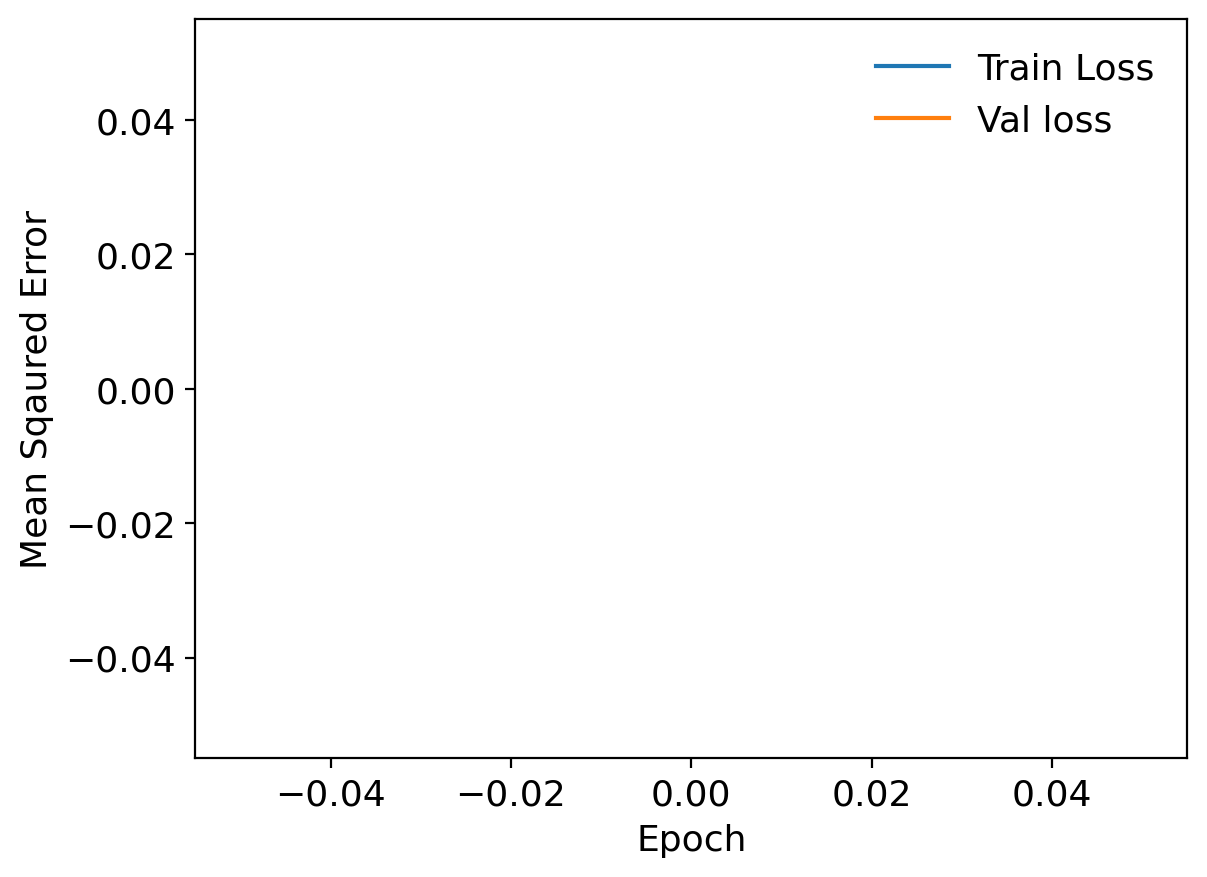

In [18]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Sqaured Error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()


plot_history(history)

In [ ]:
tas_truth = y_test_df["tas"]

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import xarray as xr
from glob import glob

import tensorflow as tf
import gpflow
from utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [19]:
z = encoder_model.predict(y_test)
y_test_pre = decoder_model.predict([z,X_test])

y_test_pre = y_test_pre*std + mean

y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)
y_test_pre = xr.Dataset(coords={'time': y_test_xr.time.values,
                               'latitude': y_test_xr.latitude.values,
                               'longitude': y_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'VAE reconstruction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(9,4))

yr,mean_truth = mean_std_plot(y_test_xr['tas'],color='tab:blue',label='tas truth',ax=ax)
yr,mean_pre   = mean_std_plot(y_test_pre['tas'],color='tab:orange',label='VAE reconstruction',ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('tas (°C)')


fig.legend(loc='upper left',bbox_to_anchor=(0.08,0.95),ncol=2)


plt.tight_layout()

In [22]:
# predict
standard_posterior_mean, standard_posterior_var = history.predict(X_test)
posterior_mean   = standard_posterior_mean * train_tas_std + train_tas_mean
posterior_std    = np.sqrt(standard_posterior_var) * train_tas_std

AttributeError: ignored

In [ ]:
y_test_pre_mean = np.reshape(posterior_mean,[posterior_mean.shape[0], 96, 144])
y_test_pre_std  = np.reshape(posterior_std,[posterior_std.shape[0], 96, 144])

y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values,
                                 'latitude': X_test_xr.latitude.values,
                                 'longitude': X_test_xr.longitude.values},
                             data_vars=dict(tas_mean=(['time', 'latitude', 'longitude'], y_test_pre_mean),
                                            tas_std=(['time', 'latitude', 'longitude'], y_test_pre_std)))

In [ ]:
# put output back into pd.DataFrame format for calculating RMSE/plotting
posterior_tas = np.reshape(posterior_mean, [86, 96, 144])
posterior_tas_std = np.reshape(posterior_std, [86, 96, 144])
posterior_tas_data = xr.DataArray(posterior_tas, dims=y_test_xr.tas.dims, coords=y_test_xr.tas.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_std, dims=y_test_xr.tas.dims, coords=y_test_xr.tas.coords)

In [ ]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(y_test_xr.tas[35], y_test_pre.tas_mean[35])}")
print(f"RMSE at 2100: {get_rmse(y_test_xr.tas[85], y_test_pre.tas_mean[85])}")
print(f"RMSE 2045-2055: {get_rmse(y_test_xr.tas[30:41], y_test_pre.tas_mean[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(y_test_xr.tas[75:], y_test_pre.tas_mean[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(y_test_xr.tas[35:], y_test_pre.tas_mean[35:]).mean()}")

# RMSE for average field over the last 20 years
print(f"RMSE average last 20y: {get_rmse(y_test_xr.tas[-20:].mean(dim='time'), y_test_pre.tas_mean[-20:].mean(dim='time'))}")

In [ ]:
import cartopy.crs as ccrs
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Air Surface Temperature')

# Test
plt.subplot(131, projection=proj)
y_test_xr.tas.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
y_test_pre.tas_mean.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = y_test_xr.tas - y_test_pre.tas_mean
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [ ]:
a = y_test_pre.to_dataframe()

In [ ]:
b = y_test_xr['tas'].to_dataframe()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming you have reconstructed output from VAE stored in a variable 'reconstructed_data'
reconstructed_data = a.to_numpy()

# Assuming you have the original input data stored in a variable 'original_data'
original_data = b.to_numpy()

# Flatten the data for calculating RMSE
reconstructed_data_flat = reconstructed_data.flatten()
original_data_flat = original_data.flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(original_data_flat, reconstructed_data_flat))

print("RMSE:", rmse)
